# 🤪 WGAN-GP - CelebA Facesデータ

本ノートブックでは，CelebA FacesデータセットでWasserstein GANを学習する．

In [6]:
!pip install japanize_matplotlib | tail -n 1
!pip install kagglehub | tail -n 1
!pip install torchinfo | tail -n 1

In [7]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchvision
import torch
import torchinfo
import random
import json
import pandas as pd
import kagglehub
from torch import nn
from torch.utils.data import DataLoader, Subset
import sys
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121
0.20.1+cu121


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# シード値を設定
set_seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


## 0. パラメータ

In [9]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 2 # 3
GP_WEIGHT = 10.0
LOAD_MODEL = False

## 1. データ準備

In [10]:
# kakgglehubを使ってダウンロード -> pathに保存
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.33G/1.33G [00:18<00:00, 76.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [11]:
# データ変換の定義
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
])

# 分割情報(訓練データとテストデータを識別する情報）を読み込む
partition_df = pd.read_csv(os.path.join(path, "list_eval_partition.csv"), header=0)
file_to_partition = dict(zip(partition_df['image_id'], partition_df['partition'])) # partition: 0=train, 1=val, 2=test

# 属性情報を読み込み
attr_df = pd.read_csv(os.path.join(path, "list_attr_celeba.csv"), header=0, index_col=0)
attr_df = (attr_df + 1) // 2  # 属性を0/1に変換（-1を0、1を1に）
MULTI_CLASSES = np.array([
    "髭の剃り残し", "アーチ型の眉毛", "魅力的", "目の下のクマ",
    "禿げている", "前髪", "大きな唇", "大きな鼻", "黒髪", "金髪",
    "ぼやけた", "茶髪", "太い眉毛", "ふっくらしている", "二重あご",
    "眼鏡", "あごひげ", "白髪", "濃い化粧", "高い頬骨",
    "男性", "口が少し開いている", "口ひげ", "細い目", "ひげなし",
    "卵型の顔", "色白の肌", "先のとがった鼻", "後退する生え際",
    "バラ色の頬", "もみあげ", "笑っている", "直毛", "ウェーブのかかった髪",
    "イヤリングをしている", "帽子をかぶっている", "口紅をしている",
    "ネックレスをしている", "ネクタイをしている", "若い"
])
attr_df.columns = MULTI_CLASSES

# カスタムImageFolderを定義 (属性を返すように)
class CustomImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, attributes=None):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform)
        self.attributes = attributes

    def __getitem__(self, index):
        # 画像とラベルを取得
        path, _ = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)

        # 属性を取得
        filename = os.path.basename(path)
        attr = self.attributes.loc[filename].values.astype(float)

        return image, attr

# カスタムデータセットを作成
full_dataset = CustomImageFolder(
    root=path,
    transform=transform,
    attributes=attr_df
)

# データセットのインデックスを分割
train_indices = [i for i, (path, _) in enumerate(full_dataset.samples) if file_to_partition[os.path.basename(path)] == 0]
test_indices = [i for i, (path, _) in enumerate(full_dataset.samples) if file_to_partition[os.path.basename(path)] == 2]

# サブセットを作成
trainset = Subset(full_dataset, train_indices)
# 学習時間が長いので学習データを絞る（本書の実装にはない）
# フルデータで学習したい場合は以下をコメントアウトしてください．
print("full train dataset len", len(trainset))
data_ratio = 0.2
subset_indices = random.sample(range(len(trainset)), int(data_ratio * len(trainset)))  # データの50%
trainset = Subset(trainset, subset_indices)
print("trainset len", len(trainset))
####
testset = Subset(full_dataset, test_indices)

# データローダーの作成
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)


# from attr_df.columns (list_attr_celeba.csv)
# MULTI_CLASSES = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
#  'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
#  'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
#  'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
#  'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
#  'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#  'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
#  'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
#  'Wearing_Necklace', 'Wearing_Necktie', 'Young']

full train dataset len 162770
trainset len 32554


tensor([[[ 1.0000,  1.0000,  1.0000,  ..., -0.5216, -0.5137, -0.5137],
         [ 1.0000,  1.0000,  1.0000,  ..., -0.5216, -0.5137, -0.5137],
         [ 1.0000,  1.0000,  1.0000,  ..., -0.5216, -0.5137, -0.5137],
         ...,
         [-0.8431, -0.8275, -0.8275,  ..., -0.8824, -0.8824, -0.8902],
         [-0.8431, -0.8275, -0.8275,  ..., -0.8667, -0.8667, -0.8667],
         [-0.8353, -0.8196, -0.8275,  ..., -0.8588, -0.8588, -0.8588]],

        [[ 1.0000,  1.0000,  1.0000,  ..., -0.5922, -0.6000, -0.6000],
         [ 1.0000,  1.0000,  1.0000,  ..., -0.5922, -0.6000, -0.6000],
         [ 1.0000,  1.0000,  1.0000,  ..., -0.5922, -0.6000, -0.6000],
         ...,
         [-0.8431, -0.8275, -0.8275,  ..., -0.9608, -0.9608, -0.9686],
         [-0.8431, -0.8275, -0.8275,  ..., -0.9451, -0.9451, -0.9451],
         [-0.8353, -0.8196, -0.8275,  ..., -0.9294, -0.9294, -0.9373]],

        [[ 1.0000,  1.0000,  1.0000,  ..., -0.5686, -0.5686, -0.5686],
         [ 1.0000,  1.0000,  1.0000,  ..., -0

(3, 64, 64)
特徴一覧：
 ['男性' '口が少し開いている' '直毛' '若い']


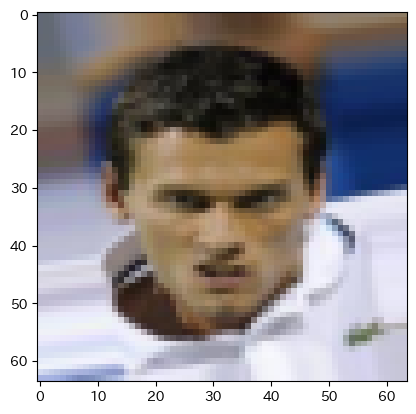

In [12]:
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
print("特徴一覧：\n",MULTI_CLASSES[trainset[1][1] == 1])
plt.imshow(trainset[1][0].permute(1,2,0)*0.5+0.5)
plt.show()

## 2. WGAN-GPモデルを構築

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 64 -> 32
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 32 -> 16
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 16 -> 8
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 8 -> 4
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=(4, 4), stride=1, padding=0, bias=False) # 4 -> 1

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(p=0.3)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.flatten(x)

        return x

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.deconv1 = nn.ConvTranspose2d(in_channels=self.latent_dim, out_channels=512, kernel_size=(4, 4), stride=1, padding=0, bias=False) # 1 -> 4
        self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 4 -> 8
        self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 8 -> 16
        self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 16 -> 32
        self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=CHANNELS, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 32 -> 64

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.batch_norm1 = nn.BatchNorm2d(num_features=512, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm2 = nn.BatchNorm2d(num_features=256, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm3 = nn.BatchNorm2d(num_features=128, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm4 = nn.BatchNorm2d(num_features=64, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), self.latent_dim, 1, 1)
        x = self.deconv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        x = self.deconv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        x = self.deconv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)
        x = self.deconv4(x)
        x = self.batch_norm4(x)
        x = self.leaky_relu(x)
        x = self.deconv5(x)
        x = self.tanh(x)

        return x


class WGANGP(nn.Module):
    def __init__(self, latent_dim, device, gp_weight, d_steps):
        super().__init__()
        self.D = Discriminator()
        self.G = Generator(latent_dim)
        self.latent_dim = latent_dim
        self.device = device
        self.d_steps = d_steps
        self.gp_weight = gp_weight
        self.d_opt = torch.optim.Adam(self.D.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, ADAM_BETA_2))
        self.g_opt = torch.optim.Adam(self.G.parameters(), lr=LEARNING_RATE, betas=(ADAM_BETA_1, ADAM_BETA_2))

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """
        1. 補完画像を生成: interpolated = real_images + alpha * (fake_images - real_images)
        2. interpolated.requires_grad_(True): 勾配計算のため，interpolatedテンソルに勾配を設定．
        3. 勾配計算: torch.autograd.gradを使用して，predに対するinterpolatedの勾配を計算．
        4. 勾配ペナルティ計算: 勾配ノルムのL2ノルムを計算し，目標の1との差を2乗して平均化．
        """
        alpha = torch.rand(size=(batch_size, 1, 1, 1), device=self.device)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        interpolated.requires_grad_(True)

        pred = self.D(interpolated)
        grads = torch.autograd.grad(outputs=pred,
                                    inputs=interpolated,
                                    grad_outputs=torch.ones_like(pred, device=self.device),
                                    create_graph=True,
                                    retain_graph=True,
                                    only_inputs=True)[0]
        norm = torch.linalg.matrix_norm(grads, ord='fro', dim=(-2, -1))
        gp = ((norm - 1) ** 2).mean()

        return gp

    def train_one_step(self, real_images):
        # 潜在空間内のランダムな点をサンプルする
        batch_size = real_images.size(0)

        # -------------------------
        # 識別器Dの学習
        # -------------------------
        self.D.train()
        for _ in range(self.d_steps):
            self.d_opt.zero_grad()
            random_latent_vectors = torch.randn(size=(batch_size, self.latent_dim), device=self.device)
            # 生成器から偽画像を生成（学習しないので勾配は計算しない）
            with torch.no_grad():
                generated_images = self.G(random_latent_vectors)

            # Discriminatorの予測
            real_predictions = self.D(real_images)
            fake_predictions = self.D(generated_images)

            # Wasserstein損失の計算
            d_wass_loss = -(real_predictions.mean() - fake_predictions.mean())
            # 勾配ペナルティの計算
            d_gp = self.gradient_penalty(batch_size, real_images, generated_images)
            d_loss = d_wass_loss + self.gp_weight * d_gp

            d_loss.backward()
            self.d_opt.step()

        # ----------------------
        # 生成器Gのトレーニング
        # ----------------------
        self.G.train()
        self.g_opt.zero_grad()
        random_latent_vectors = torch.randn(size=(batch_size, self.latent_dim), device=self.device)
        # 生成器から偽画像を生成
        generated_images = self.G(random_latent_vectors)
        fake_predictions = self.D(generated_images)  # 以下ではg_optimzerを使うのでパラメータは更新されない

        # Wasserstein損失の計算
        g_loss = - fake_predictions.mean()

        g_loss.backward()
        self.g_opt.step()

        # メトリクスの記録
        metrics = {
            "d_loss": d_loss.item(),
            "d_wass_loss": d_wass_loss.item(),
            "d_gp": d_gp.item(),
            "g_loss": g_loss.item(),
        }

        return metrics

    def forward(self):
        pass

In [14]:
wgangp = WGANGP(latent_dim=Z_DIM, device=device, gp_weight=GP_WEIGHT, d_steps=CRITIC_STEPS)
wgangp.eval()

WGANGP(
  (D): Discriminator(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (dropout): Dropout(p=0.3, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (G): Generator(
    (deconv1): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

In [15]:
torchinfo.summary(wgangp.G.eval(), input_size=(1, Z_DIM), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─ConvTranspose2d: 1-1                   [1, 512, 4, 4]            1,048,576
├─BatchNorm2d: 1-2                       [1, 512, 4, 4]            1,024
├─LeakyReLU: 1-3                         [1, 512, 4, 4]            --
├─ConvTranspose2d: 1-4                   [1, 256, 8, 8]            2,097,152
├─BatchNorm2d: 1-5                       [1, 256, 8, 8]            512
├─LeakyReLU: 1-6                         [1, 256, 8, 8]            --
├─ConvTranspose2d: 1-7                   [1, 128, 16, 16]          524,288
├─BatchNorm2d: 1-8                       [1, 128, 16, 16]          256
├─LeakyReLU: 1-9                         [1, 128, 16, 16]          --
├─ConvTranspose2d: 1-10                  [1, 64, 32, 32]           131,072
├─BatchNorm2d: 1-11                      [1, 64, 32, 32]           128
├─LeakyReLU: 1-12                        [1, 64, 32, 32

In [16]:
torchinfo.summary(wgangp.D.eval(), input_size=(1, 3, 64, 64), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 32, 32]           3,072
├─LeakyReLU: 1-2                         [1, 64, 32, 32]           --
├─Conv2d: 1-3                            [1, 128, 16, 16]          131,072
├─LeakyReLU: 1-4                         [1, 128, 16, 16]          --
├─Dropout: 1-5                           [1, 128, 16, 16]          --
├─Conv2d: 1-6                            [1, 256, 8, 8]            524,288
├─LeakyReLU: 1-7                         [1, 256, 8, 8]            --
├─Dropout: 1-8                           [1, 256, 8, 8]            --
├─Conv2d: 1-9                            [1, 512, 4, 4]            2,097,152
├─LeakyReLU: 1-10                        [1, 512, 4, 4]            --
├─Dropout: 1-11                          [1, 512, 4, 4]            --
├─Conv2d: 1-12                           [1, 1, 1, 1]            

### 参考) 自動微分周りの挙動確認

In [17]:
# torch.autograd.gradの挙動確認

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

Q = 2*a**3 - b**2

grad = torch.autograd.grad(
    outputs = Q,
    inputs = a,
    grad_outputs = torch.tensor([1, 1]),
    create_graph = True, # 勾配の計算に必要な新しい計算グラフを作成し，高階微分（2次勾配など）の計算に必要
    retain_graph = False, # 計算グラフを保持し，同じ計算を再利用できるようにする(同じ勾配の累積)
    only_inputs = True # Trueのとき，出力変数に関する勾配計算をinputsに限定（他の変数に対しては計算しない）
)
print(grad)
grad2 = torch.autograd.grad(
    outputs = grad[0],
    inputs = a,
    grad_outputs = torch.tensor([1, 1]),
    create_graph = True, # 勾配の計算に必要な新しい計算グラフを作成し，高階微分（2次勾配など）の計算に必要
    retain_graph = False, # 計算グラフを保持し，同じ計算を再利用できるようにする(同じ勾配の累積)
    only_inputs = True # Trueのとき，出力変数に関する勾配計算をinputsに限定（他の変数に対しては計算しない）
)
print(grad2)

(tensor([24., 54.], grad_fn=<MulBackward0>),)
(tensor([24., 36.], grad_fn=<MulBackward0>),)


In [18]:
# create_graphの挙動確認

x = torch.tensor(2.0, requires_grad=True)
y = x ** 4

# create_graph=Trueを使って勾配計算用のグラフを生成
grad_y = torch.autograd.grad(y, x, create_graph=True)[0]
print(grad_y)  # xに関するyの勾配は12（3 * x^2）

# さらにその勾配（2次勾配）を計算
grad2_y = torch.autograd.grad(grad_y, x)[0]
print(grad2_y)  # 2次勾配は12

tensor(32., grad_fn=<MulBackward0>)
tensor(48.)


In [19]:
# retain_graphの挙動確認
# ※retain_graphのデフォルト値：Defaults to the value of create_graph.
x = torch.tensor(2.0, requires_grad=True)
y = x ** 4

# 1. backwardでの計算
y.backward(create_graph=False, retain_graph=True)
print(x.grad) # 1回目のy.backward()で，dy/dx = 32が x.grad に保存される
y.backward(create_graph=False, retain_graph=True)
print(x.grad) # 2回目のy.backward()で，さらに同じ勾配32が加算され，結果としてx.gradは64になる

# 2. autograd.gradでの計算
grad_y = torch.autograd.grad(y, x, create_graph=False, retain_graph=True)[0]
print(grad_y)
grad2_y = torch.autograd.grad(y, x, create_graph=False)[0]
print(grad2_y)

tensor(32.)
tensor(64.)
tensor(32.)
tensor(32.)


## 3. WGAN-GPモデルの学習

In [24]:
def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)  # ディレクトリを作成
    model.eval()
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

### 学習は以下(GPU推奨)

In [21]:
# metrics_per_epoch = {
#     "d_loss": [],
#     "d_wass_loss": [],
#     "d_gp": [],
#     "g_loss": [],
# }
# wgangp = wgangp.to(device)

# # 保存するエポックをリストで指定
# save_epochs = [1, 50, 100, 150, 200]

# for epoch in range(EPOCHS):
#     epoch_metrics = {metric: 0 for metric in metrics_per_epoch}
#     batch_count = 0

#     for i, data in enumerate(trainloader, 0):
#         inputs, _ = data
#         inputs = inputs.to(device)

#         # ミニバッチ学習
#         metrics = wgangp.train_one_step(inputs)

#         for key in epoch_metrics:
#             epoch_metrics[key] += metrics[key]

#         batch_count += 1

#     # エポックのメトリクス平均を計算して保存
#     for key in epoch_metrics:
#         epoch_metrics[key] /= batch_count
#         metrics_per_epoch[key].append(epoch_metrics[key])

#     # メトリクスの出力
#     print("Epoch {}:".format(epoch + 1), epoch_metrics)

#     # 指定したエポックのみ保存
#     if (epoch + 1) in save_epochs:

#         # モデルを保存
#         save_path = f"./models/07_wgangp_model_epoch_{epoch + 1}.pth"
#         save_model(wgangp, save_path)
#         print(f"Model saved to {save_path}")

In [22]:
# save_path = f"./models/07_wgangp_model_epoch_{EPOCHS}.pth"
# save_model(wgangp, save_path)

# metrics_save_path = f"./metrics/07_wgangp_metrics.json"
# with open(metrics_save_path, "w") as f:
#     json.dump(metrics_per_epoch, f)
# print(f"Metrics saved to {metrics_save_path}")

### 学習済みモデルのロードは以下

In [25]:
import urllib.request

# モデルのURL
model_url = "https://github.com/sol-sun/Generative_Deep_Learning_2nd_Pytorch/raw/main/04_gan/models/wgangp_model_epoch_200.pth"
local_model_path = "wgangp_model_epoch_200.pth"

# モデルをダウンロード
urllib.request.urlretrieve(model_url, local_model_path)
# Move the model to the device and load it
wgangp = load_model(wgangp, local_model_path, device)

Model loaded from wgangp_model_epoch_200.pth


## 4. 画像を生成する

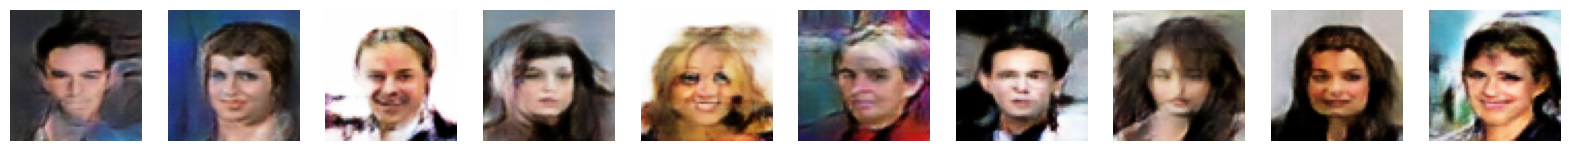

In [26]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.G(torch.from_numpy(z_sample).float().to(device))*0.5+0.5 # [0, 1]に変換

fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    ax[i].imshow(imgs[i].permute(1, 2, 0).detach().cpu().numpy())
    ax[i].axis("off")